# Northwind BI
- Autor: Alvaro Fuentes d'alencon
- Github: https://github.com/alvarofda

## 1.- Problema

Northwind es una empresa dedicada a la importación y exportación de items de comida y bebida de lujo. Esta empresa no es data-driven, y por ahora, los gerentes quieren comenzar el área de Análisis de Datos por dos líneas: Segmentación de Clientes en base a uso de categorías, y Tasa de Fuga de Clientes.

Para llevar a cabo su trabajo, se le disponibiliza una base de datos en SQLite con una extracción de la tabla. A continuación un detalle de algunas tablas relevantes en conjunto con la estrutura de las tablas:

-	suppliers: Proveedores de Northwind
-	customers: Clientes de Northwind
-	employees: Detalles de empleados de Northwind
-	shippers: Empresas/personas que realizan los envíos a los clientes finales
-	orders y order_details: Ordenes hechas por clientes y el detalle (línea de factura) de cada orden.

<p align="center">
  <img width="800" height="600" src='erdiagram.png'>
</p>

**NOTAS:** 
1. La entrega considera el código que ud. haga más el material para responder a las preguntas (i.e. Slides o Texto en PDF)
2. Anote todos sus supuestos.
3. Es libre de hacer este desafio con el lenguaje que quiera, pero se apreciará el uso de SQL.
4. Esta base de datos es de ejemplo, aquí la idea es que ud muestre que
	1. Puede resolver a nivel de código
	2. Puede interpretar los resultados, independiente de cuales sean estos.
	3. Hipotetizar siguientes pasos (i.e. conseguir más data, proponer validar la data, etc).

## 2.- Desarrollo

Comenzamos importando librerias a utilizar y generando las conecciones necesarias

In [106]:
# Librerias a utilizar
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Nos conectamos a la base de datos
conn = sqlite3.connect('Northwind_large.sqlite')

# Observamos las tablas que contiene la BD.
tables = pd.read_sql('SELECT * FROM sqlite_master WHERE type = "table";', conn)
tables.loc[:,['type', 'name', 'tbl_name']]

,type,name,tbl_name
0,table,Employee,Employee
1,table,Category,Category
2,table,Customer,Customer
3,table,Shipper,Shipper
4,table,Supplier,Supplier
5,table,Order,Order
6,table,Product,Product
7,table,OrderDetail,OrderDetail
8,table,CustomerCustomerDemo,CustomerCustomerDemo
9,table,CustomerDemographic,CustomerDemographic


Observamos que la base de datos contiene 13 tablas. En conjunto con el software dBeaver se observaron los datos y se construyeron las querys que se utilzan más adelante.

### 2.1.- Preguntas básicas

#### 2.1.1 - Pregunta 1 

Grafique la evolución de la venta total en transacciones y monto total, y comente al respecto.
- 1. Elija ud. la temporalidad (semanal, mensual, anual, Qs, Hs, etc) y ofrezca alguna justificación en base a lo que conoce del mercado, los datos y supuestos. 

**Respuesta:**

Para contestar esta pregunta, previamente revisamos el diagrama entidad-relacion.  Segun lo observado, utilizaré las tablas 'Order' y 'OrderDetail'. Para esto podemos realizar un innerjoin utilizando el campo Id.Order como enlace:

In [3]:
# Generamos query para extraer los datos con los campos que necesitamos
query_1 = pd.read_sql("""
    SELECT o.id, o.CustomerId, o.OrderDate, od.UnitPrice, od.Quantity, od.Discount
    FROM "Order" AS o
    INNER JOIN OrderDetail AS od
    ON od.OrderId = o.Id;""", conn)

query_1.head()

,Id,CustomerId,OrderDate,UnitPrice,Quantity,Discount
0,10248,VINET,2012-07-04,14.0,12,0.0
1,10248,VINET,2012-07-04,9.8,10,0.0
2,10248,VINET,2012-07-04,34.8,5,0.0
3,10249,TOMSP,2012-07-05,18.6,9,0.0
4,10249,TOMSP,2012-07-05,42.4,40,0.0


Como necesitamos el monto de la transaccion, este se calcula de la siguiente manera:

<p align="center">Mount = UnitPrice * Quantity - Discount</p>

El resultado se guarda en una nueva columna llamada 'Mount':

In [4]:
# Calculamos el monto de cada venta
query_1['Mount'] = query_1['UnitPrice'] * query_1['Quantity'] - query_1['Discount']
query_1.sample()

,Id,CustomerId,OrderDate,UnitPrice,Quantity,Discount,Mount
113231,13957,HANAR,2015-10-24 20:53:30,62.5,32,0.0,2000.0


Ahora podemos agrupar por dia de la orden (OrdenDate) y sumar los montos por dia

In [5]:
# Agrupaos por Id y fecha de orden
query_1 = query_1.groupby(['Id', 'OrderDate'])['Mount'].sum().reset_index()
query_1.sample(5)

,Id,OrderDate,Mount
2452,12700,2012-08-28 01:27:07,32291.80
11450,21698,2015-06-19 22:24:43,470.00
9846,20094,2012-07-30 11:20:41,28123.31
1723,11971,2012-09-07 18:45:19,22241.36
9767,20015,2015-08-08 11:28:20,33509.70


Cambiamos el tipo de dato de la columnas OrderDate utilizando la función "DateTime". Cabe destacar que utilizaremos como unidad temporal **mes**. Ahora calculamos los montos y transacciones por mes y graficamos:

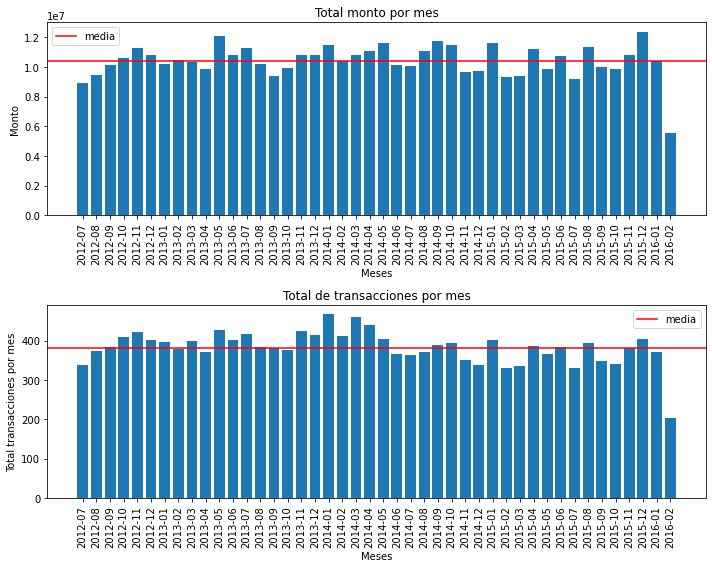

In [6]:
# Formateamos a tipo datetime
query_1['OrderDate'] = pd.to_datetime(query_1['OrderDate'], format='%Y-%m').dt.strftime('%Y-%m')

# Generamos groupby para poder graficar
mount_year = query_1.groupby(['OrderDate'])['Mount'].sum().reset_index()
trans_year = query_1.groupby(['OrderDate'])['Id'].count().reset_index()

# Gráficos
plt.rcParams["figure.figsize"] = (10, 8)
plt.subplot(2, 1, 1)
plt.bar(mount_year['OrderDate'], mount_year['Mount'])
plt.axhline(mount_year['Mount'].mean(), c='red', label='media')
plt.title('Total monto por mes')
plt.xlabel("Meses")
plt.ylabel("Monto")
plt.legend()
plt.xticks(rotation=90)
plt.subplot(2, 1, 2)
plt.bar(trans_year['OrderDate'], trans_year['Id'])
plt.axhline(trans_year['Id'].mean(), c='red', label='media')
plt.title('Total de transacciones por mes')
plt.xlabel("Meses")
plt.ylabel("Total transacciones por mes")
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



**Análisis**

- ¿Por que se elige la temporalidad mensual? Como es una empresa de distribución de alimentos lujosos, podriamos tender a pensar que existe una tenendica en las transacciones y montos a traves del tiempo. Por ejemplo, en ciertos meses (dependiendo del territorio) podria existir ciertas alzas de ventas por motivos de alguna festividad. 

- Si observamos el gráfico "total transacciones por mes", podemos detectar algunos "peak" en ciertos meses que sobrepasan la media. Por ejemplo: 11-2012, 05-2013, 01-2014, etc. Sobre todo en el periodo de tiempo que comprende desde 11-2013 al 05-2014.

- Tomando lo anteriormente mencionado, esto se condice con lo mostrado en el gráfico de "Montos por mes". Para el periodo previamente descrito (11-2013 al 05-2014), siempre se recaudó montos por sobre la media.

#### 2.1.2 - Pregunta 2

¿Cuál es la venta total (transacciones y monto total) desagregada por Categoria de Producto en el último año cerrado (2015), entregado en porcentajes y totales? 
- 1. Con esta data, elija cuantativa y cualitativamente 4 o 5 categorias en las que enfocarse (esta permitido generar super-grupos de categorias).

**Respuesta**

Generamos la query para extraer los datos desde la BD. Para el desarrollo del ejercicio utilizaremos las columnas OrderId, OrderDate, CategoryId, UnitPrice, Quantity y Discount

In [7]:
# Generamos query para extraer los datos con los campos que necesitamos
query_2 = pd.read_sql("""SELECT o.id, o.OrderDate, sub.CategoryId, sub.UnitPrice, sub.Quantity, sub.Discount
    FROM "Order" as o
    INNER JOIN (select p.id, p.CategoryId, od.OrderId, od.UnitPrice, od.Quantity, od.Discount
    FROM Product as p
    INNER JOIN OrderDetail as od 
    ON p.Id = od.ProductId) as sub
    ON o.id = sub.OrderId;""", conn)

Como el ejercicio solicita trabajar solo con el año 2015, solo seleccionaremos los registros correspondientes a este año

In [8]:
query_2['OrderDate'] = pd.to_datetime(query_2['OrderDate'])
query_2['Year'] = query_2['OrderDate'].dt.year
query_2_2015 = query_2[query_2['Year']==2015]
query_2_2015.head()


,Id,OrderDate,CategoryId,UnitPrice,Quantity,Discount,Year
2204,11079,2015-09-05 12:04:58,3,9.2,30,0.0,2015
2205,11079,2015-09-05 12:04:58,6,39.0,5,0.0,2015
2206,11079,2015-09-05 12:04:58,2,43.9,27,0.0,2015
2207,11079,2015-09-05 12:04:58,6,24.0,37,0.0,2015
2208,11079,2015-09-05 12:04:58,4,34.0,35,0.0,2015


Al igual que el ejercicio anterior calculamos los montos en base a la misma formula utilizada en la pregunta 1:
<p align="center">Mount = UnitPrice * Quantity - Discount</p>

In [9]:
# Calculamos monto por venta
query_2_2015['Mount'] = query_2_2015['UnitPrice'] * query_2_2015['Quantity'] - query_2_2015['Discount']
query_2_2015.head()

,Id,OrderDate,CategoryId,UnitPrice,Quantity,Discount,Year,Mount
2204,11079,2015-09-05 12:04:58,3,9.2,30,0.0,2015,276.0
2205,11079,2015-09-05 12:04:58,6,39.0,5,0.0,2015,195.0
2206,11079,2015-09-05 12:04:58,2,43.9,27,0.0,2015,1185.3
2207,11079,2015-09-05 12:04:58,6,24.0,37,0.0,2015,888.0
2208,11079,2015-09-05 12:04:58,4,34.0,35,0.0,2015,1190.0


Por último. agrupamos por categoría y obtenemos los montos totales por categoría ademas de su proporción.

In [10]:
# Agrupamos y calculamos monto y proporción.
mount_2015 = query_2_2015.groupby(['CategoryId'])['Mount'].sum().reset_index()
mount_2015['Mount_%'] = round(mount_2015['Mount']/mount_2015['Mount'].sum()*100,2)
mount_2015

,CategoryId,Mount,Mount_%
0,1,25940925.25,20.65
1,2,15568229.40,12.39
2,3,18506517.61,14.73
3,4,16041504.30,12.77
4,5,8028222.25,6.39
5,6,18360844.46,14.62
6,7,9128705.50,7.27
7,8,14030712.06,11.17


Para completar aun más la respuesta, generamos un grafico de barras con los montos por categoria y un grafico de torta para ver la proporción de estos

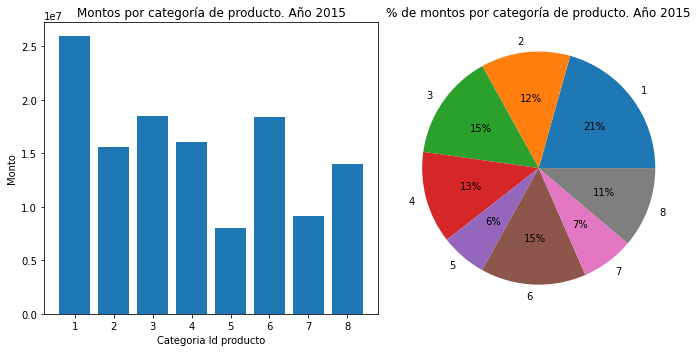

In [11]:
# Gráficos de barras y pie
plt.rcParams["figure.figsize"] = (10,5)
plt.subplot(1, 2, 1)
plt.bar(mount_2015.CategoryId, mount_2015.Mount)
plt.title('Montos por categoría de producto. Año 2015')
plt.xlabel("Categoria Id producto")
plt.ylabel("Monto")
plt.tight_layout()
plt.subplot(1,2,2)
plt.pie(mount_2015['Mount_%'], labels = mount_2015['CategoryId'], autopct='%.0f%%')
plt.title('% de montos por categoría de producto. Año 2015')
plt.tight_layout()
plt.show()

Para obtener la cantidad y proporción de las transacciones agrupamos por categoria y contamos la cantidad de Id's

In [12]:
trans_2015 = query_2_2015.groupby(['CategoryId'])['Id'].count().reset_index().rename(columns = {'Id': 'count_trans'})
trans_2015['%_trans'] = round(trans_2015['count_trans']/trans_2015['count_trans'].sum(),2)*100
trans_2015

,CategoryId,count_trans,%_trans
0,1,26443,16.0
1,2,26448,16.0
2,3,28765,17.0
3,4,21927,13.0
4,5,15395,9.0
5,6,13371,8.0
6,7,11068,7.0
7,8,26538,16.0


Para completar aun más la respuesta, generamos un grafico de barras con los montos por categoria y un grafico de torta para ver la proporción de estos

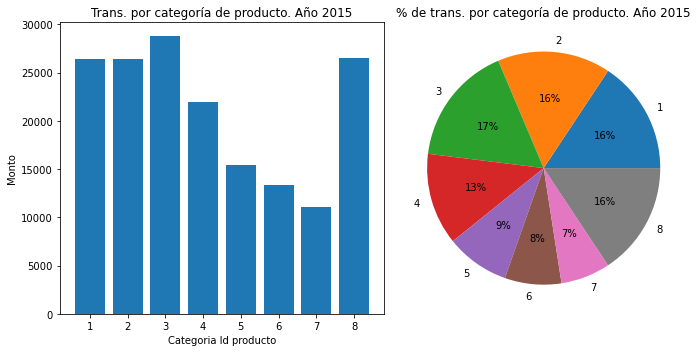

In [13]:
plt.rcParams["figure.figsize"] = (10,5)
plt.subplot(1, 2, 1)
plt.bar(trans_2015.CategoryId, trans_2015.count_trans)
plt.title('Trans. por categoría de producto. Año 2015')
plt.xlabel("Categoria Id producto")
plt.ylabel("Monto")
plt.tight_layout()
plt.subplot(1,2,2)
plt.pie(trans_2015['%_trans'], labels = trans_2015['CategoryId'], autopct='%.0f%%')
plt.title('% de trans. por categoría de producto. Año 2015')
plt.tight_layout()
plt.show()

Las categorias junto con su descripción son:

In [14]:
# Tabla categoría de los productos y su descripción
category_table = pd.read_sql('SELECT * FROM Category', conn)
category_table

,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"
5,6,Meat/Poultry,Prepared meats
6,7,Produce,Dried fruit and bean curd
7,8,Seafood,Seaweed and fish


**Selección de Categorías**
- Categoría 1 'Beverages'. Categoría que más recaudo en el año 2015.
- Categoría 3 'Confections'. Categoría que mas transacciones tuvo el año 2015.
- Categoria 5 'Grains/Cereals'. Categoría que menos recaudo en el año 2015.
- Categoría 7 'Produce'. Categoría que menos transacciones tuvo en el año 2015.

#### 2.1.3 - Pregunta 3

Para los niveles de categorías elegidas/seleccionadas, muestre la evolución histórica de la participación de cada una en forma relativa (todo suma 100% por fecha). 
- 1. Continue con la temporalidad seleccionada en 1.1.
- 2. Comente si es que ve algo de interés.

Para responder esta pregunta utilizaremos la misma query utilizada en la pregunta 2. Filtraremos por las categorías seleccionadas ademas volveremos a formatear la fecha para dejarla en unidad de Mes. Además agrupamos por categoría y contamos la cantidad de transacciones

In [147]:
# Filtramos query solo dejando los registros correspondientes a las categorías seleccionadas
query_2 = query_2[(query_2['CategoryId']==1) | (query_2['CategoryId']==3) | (query_2['CategoryId']==5) | (query_2['CategoryId']== 7)]
query_2.head()

,Id,OrderDate,CategoryId,UnitPrice,Quantity,Discount,Year
1,10248,2012-07,5,9.8,10,0.00,2012
3,10249,2012-07,7,18.6,9,0.00,2012
4,10249,2012-07,7,42.4,40,0.00,2012
6,10250,2012-07,7,42.4,35,0.15,2012
8,10251,2012-07,5,16.8,6,0.05,2012


In [148]:
# Formateamos OderDate
query_2['OrderDate'] = pd.to_datetime(query_2['OrderDate'], format='%Y-%m').dt.strftime('%Y-%m')
# Agrupamos por categoria y contamos la cantidad de transacciones
cat_part = query_2.groupby(['CategoryId', 'OrderDate'])['Id'].count().reset_index().rename(columns={'Id':'cant_trans'})
cat_part.head()

,CategoryId,OrderDate,cant_trans
0,1,2012-07,1887
1,1,2012-08,2019
2,1,2012-09,2169
3,1,2012-10,2229
4,1,2012-11,2441


Ahora generamos los gráficos para ver el histórico de participación (transacciones) para cada una de las categorías seleccionadas.

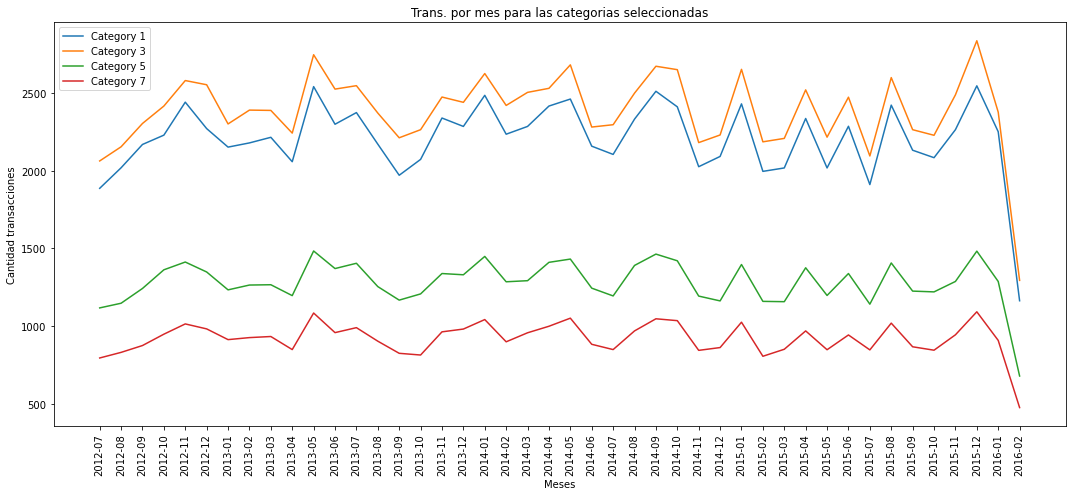

In [16]:
# Generamos lista vacia para guardar dataframes filtrados por categoria
list_df_q = []
for i in cat_part['CategoryId'].unique():
    list_df_q.append(cat_part[cat_part['CategoryId']==i])

# Generamos grafico de linea
fig=plt.figure(figsize=(15,7))
for i, d in enumerate(list_df_q):

    plt.plot(d['OrderDate'], d['cant_trans'], label="Category {}".format(cat_part['CategoryId'].unique()[i]))
    plt.title('Trans. por mes para las categorias seleccionadas')
    plt.xticks(rotation=90)
    plt.xlabel("Meses")
    plt.ylabel("Cantidad transacciones")
    plt.legend()

fig.tight_layout()  
plt.show()

**Análisis**

- Para las categorias 5 y 7 (Grains/Cereals y Produce respectivamente). Se puede observar que el comportamiento de ambas es casi idéntico. La única diferencia es que la categoría 5 presenta una mayor cantidad de transacciones a traves de todos los meses.
- Lo mismo ocurre para las categorias 1 y 3 (Beverages y Confections respectivamente). Se puede observar que tambien presentan un comportamiento casi idéntico a traves de los meses. Eso si, la diferencia entre transacciones es menor que en las dos categorias anteriores.

### 2.2 - Preguntas medianas

#### 2.2.1 - Pregunta 5 (en teoría seria la pregunta 4 pero en el pdf se salta la numeración)

Revise la distribución de compras de clientes móvil en base a categorias y determine al menos 2 segmentos en los que separar a los clientes en base a estas compras que realizan y justifiquelo. 

**Respuesta**

Para esto generamos una nueva query y extraemos los datos desde los campos de nuestro interes. Luego generamos un groupby el cual agrupe por Id de categoría y por cliente (customer).

In [149]:
# Generamos la nueva query y la guardamos en un dataframe
query_5 = pd.read_sql("""SELECT sub3.OrderId, sub3.OrderDate, sub3.ProductId, sub3.Quantity, sub3.ProductName, sub3.CategoryId, sub3.CategoryName, c2.Id as CustomerId, c2.CompanyName, c2.City, c2.Region, c2.Country
    FROM Customer as c2 
    INNER JOIN (SELECT o.Id as OrderId, o.CustomerId, o.OrderDate, sub2.ProductId, sub2.Quantity, sub2.ProductName, sub2.CategoryId, sub2.CategoryName
    FROM "Order" as o 
    INNER JOIN (SELECT od.OrderId, od.ProductId, od.Quantity, sub1.ProductName, sub1.CategoryId, sub1.CategoryName
    FROM OrderDetail as od
    INNER JOIN (SELECT p.id as ProductId, p.ProductName, p.CategoryId, c.CategoryName 
    FROM Product as p
    INNER JOIN Category as c 
    ON p.CategoryId = c.Id) as sub1 
    ON od.ProductId = sub1.ProductId) as sub2
    ON o.Id = sub2.OrderId) as sub3
    ON c2.Id = sub3.CustomerId; """, conn)

# Filtramos por las categorias seleccionadas
# select_category = query_5[(query_5['CategoryId']==1) | (query_5['CategoryId']==3) | (query_5['CategoryId']==5) | (query_5['CategoryId']== 7)]

# Agrupamos por categorias y contamos la cantidad de transacciones
query_5_gb = query_5.groupby(['CategoryId','CustomerId'])['OrderId'].count().reset_index().rename(columns={'OrderId':'cant_trans'})
query_5_gb.head()

,CategoryId,CustomerId,cant_trans
0,1,ALFKI,1182
1,1,ANATR,1105
2,1,ANTON,1074
3,1,AROUT,950
4,1,BERGS,1215


Luego generamos los gráficos de barras por cada cliente separado por categorias de producto: 

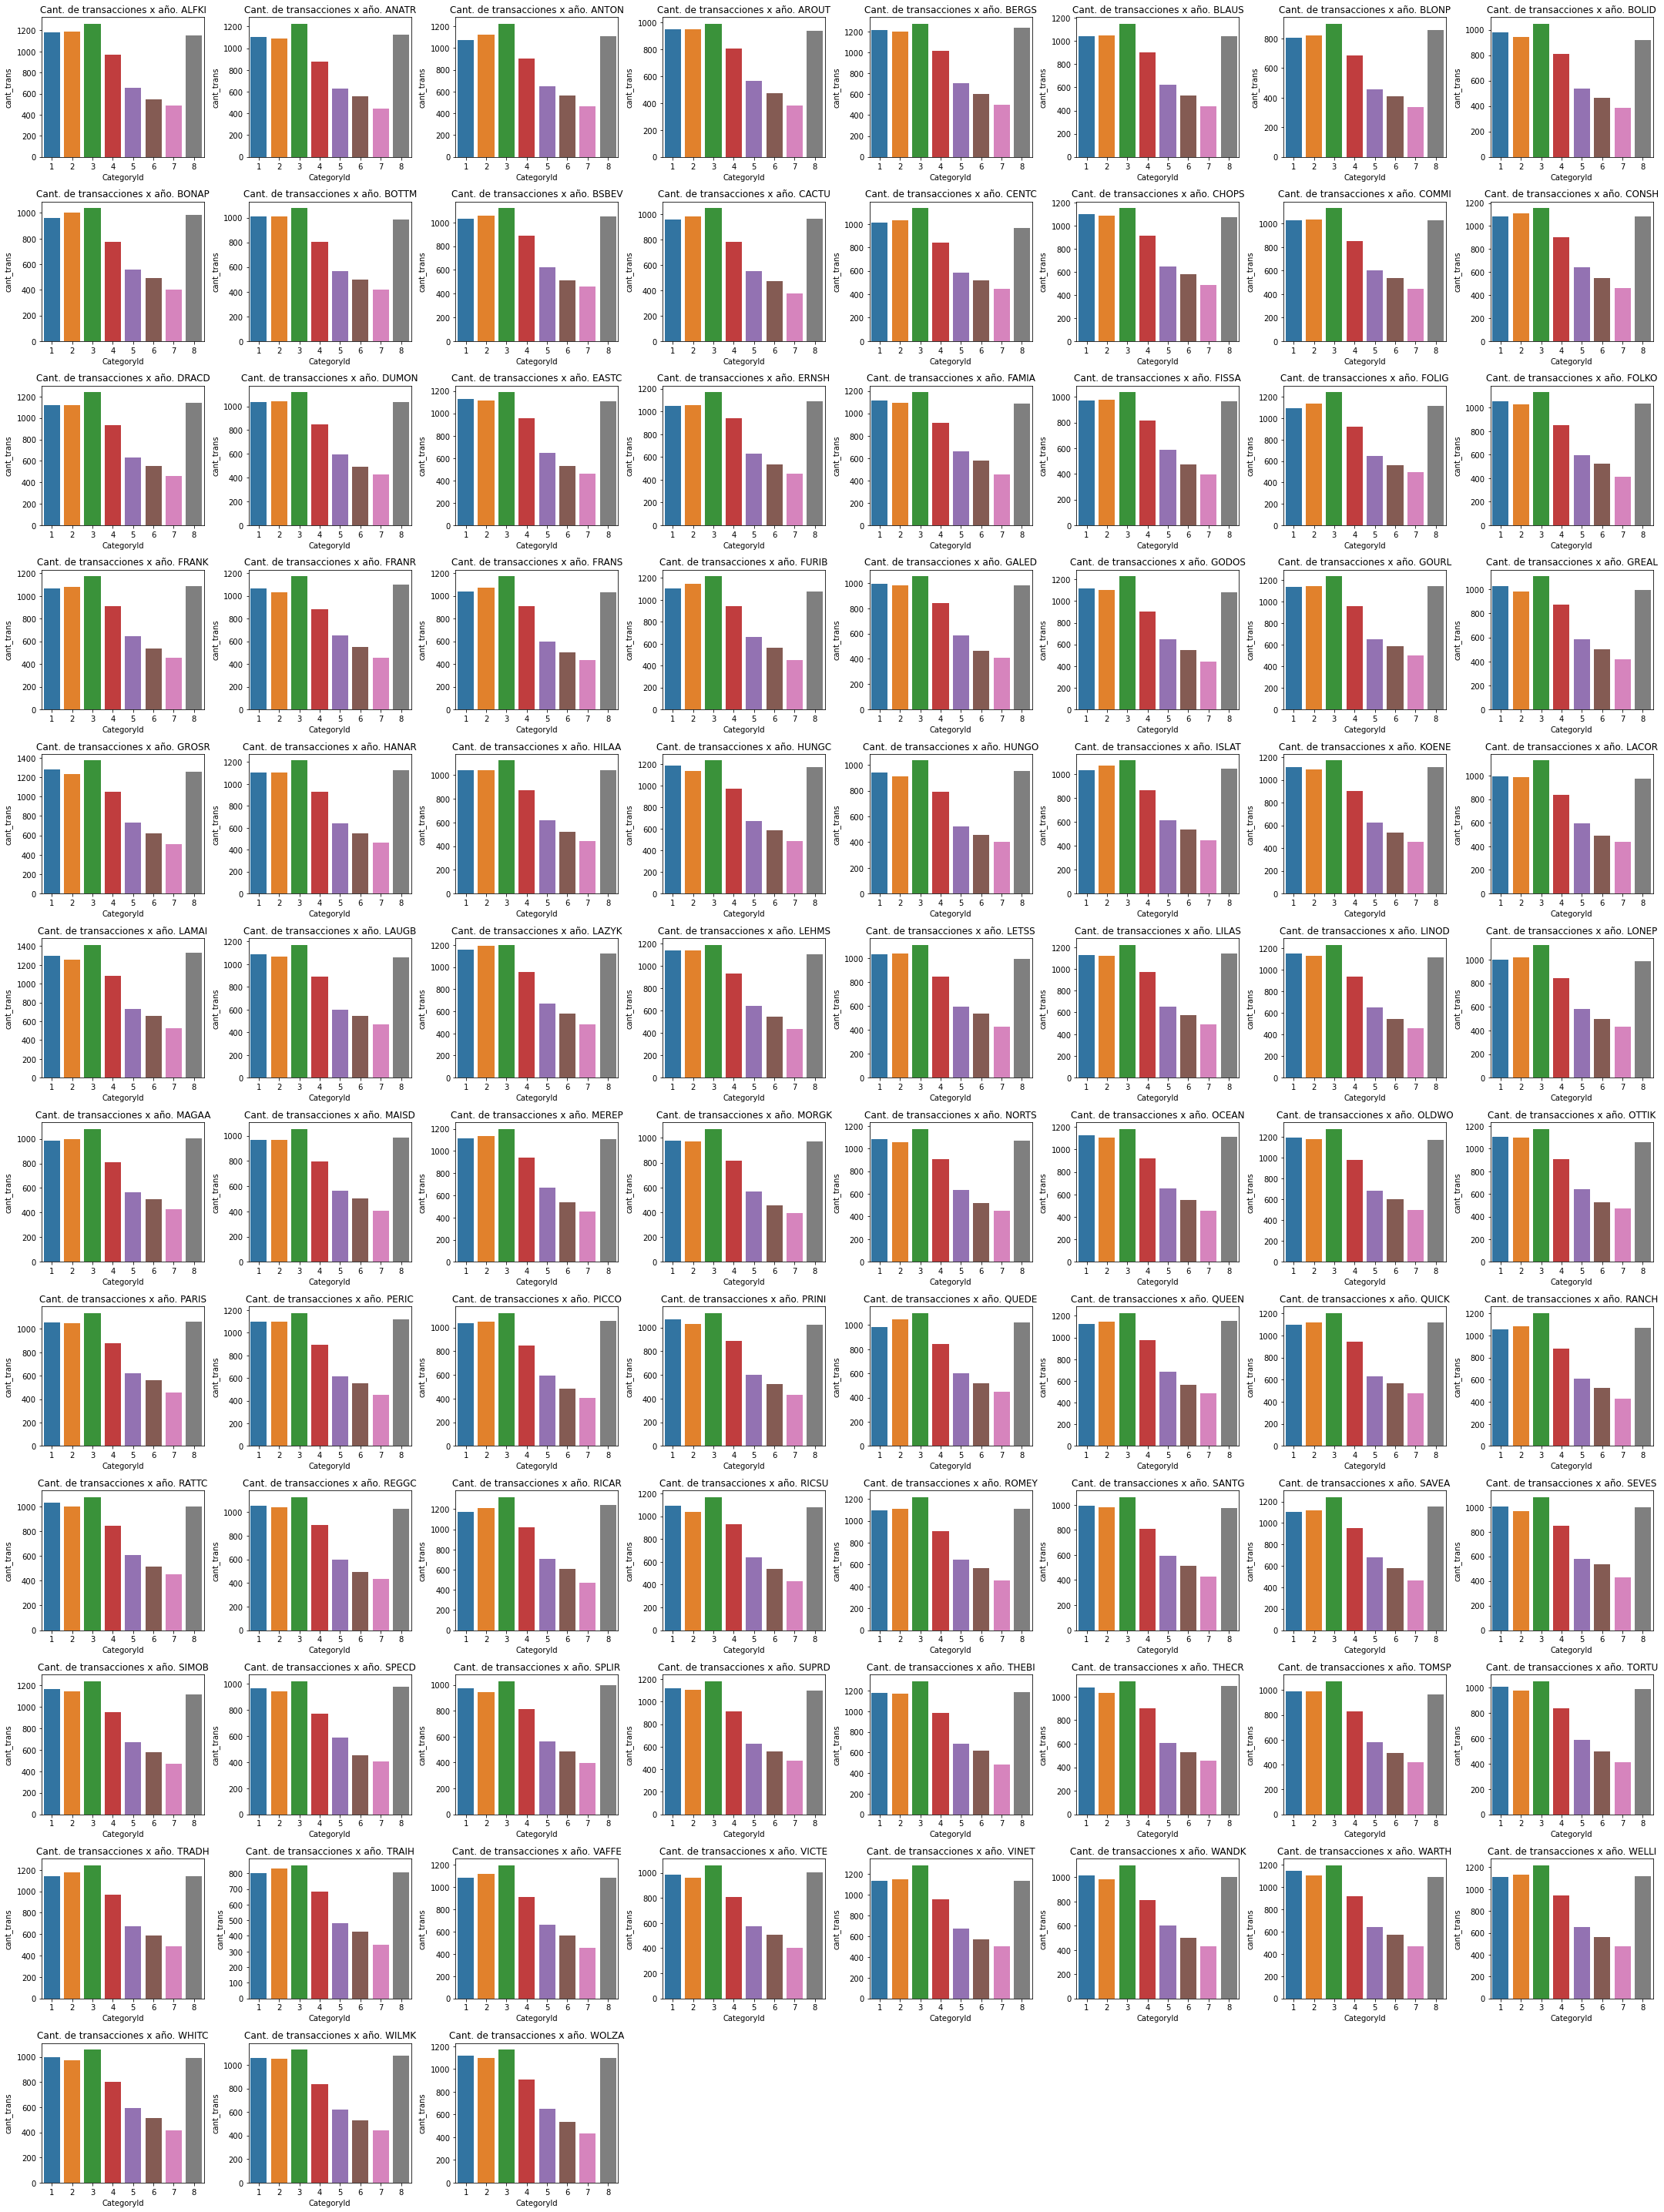

In [36]:
# Generamos lista vacia para guardar dataframes filtrados por categoria

list_df_q = []
for i in query_5_gb['CustomerId'].unique():
    list_df_q.append(query_5_gb[query_5_gb['CustomerId']==i])

# Graficamos barplot
fig=plt.figure(figsize=(30,40))
for i, d in enumerate(list_df_q):
    ax=fig.add_subplot(12,8,i+1)
    sns.barplot(x="CategoryId", y="cant_trans", data=d)
    plt.title('Cant. de transacciones x año. {}'.format(d['CustomerId'].unique()[0]))
    
fig.tight_layout()
plt.show()


**Análisis**

Al observar el gráfico, las distribuciones de ventas (transacciones) por categoría es muy similar entre los clientes. Según lo observado en la data y los gráficos, se vuelve un poco difuso aplicar segmentación por categoria de producto. Si se quisiera implementar una estrategia de marketing, esta debería ser la misma para todos ya que estos presentan el mismo comportamiento de venta. Solo difiere en la cantidad de transacciones.

¿Que podemos hacer? Tratar de buscar otro parámetro de segmentación. Quizas una buena idea seria por zona geográfica (Región). Veamos:

In [37]:
# Frecuencia de ventas por región
query_5['Region'].value_counts()

Western Europe     190006
South America      113903
North America      108379
Southern Europe     66424
British Isles       53006
Central America     34060
Northern Europe     28773
Scandinavia         20247
Eastern Europe       7008
Name: Region, dtype: int64

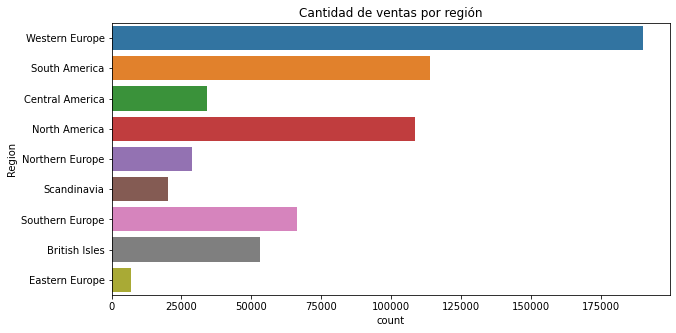

In [38]:
# Grafico cantidad de ventas por region
sns.countplot(y=query_5['Region'])
plt.title('Cantidad de transacciones por región')
plt.show()

Podemos observar que existen dos grupos bien notorios a lo que a cantidad de transacciones se refiere. Existe un grupo (WE, SA y NA) que superan las 100000 ventas. Las demas se encuentran muy por debajo de este número. Observemos si este comportamiento ocurre por año.

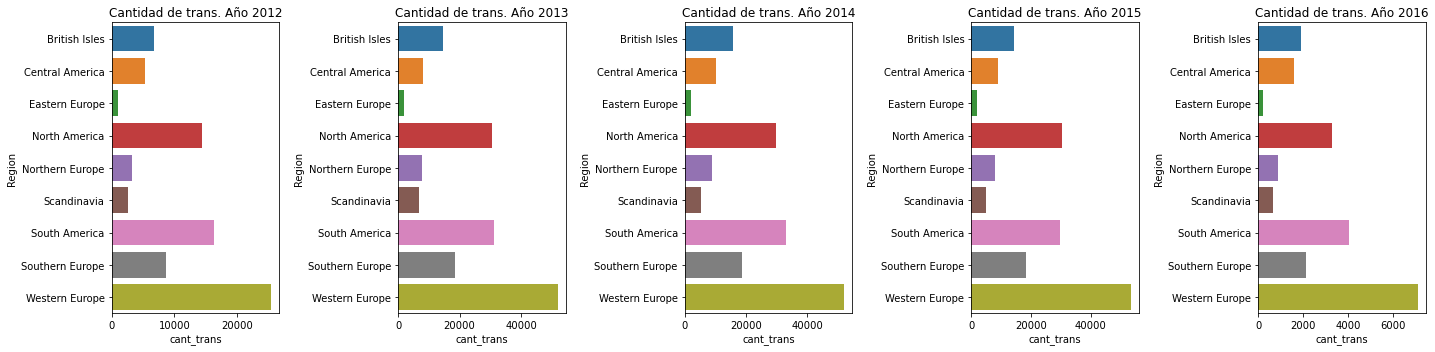

In [54]:
# Generamos lista vacia para guardar dataframes filtrados por categoria
query_5['OrderDate'] = pd.to_datetime(query_5['OrderDate'])
query_5['Year']=query_5['OrderDate'].dt.year
q = query_5.groupby(['Region', 'Year'])['OrderId'].count().reset_index().rename(columns={'OrderId':'cant_trans'})

# Generamos lista vacia para guardar dataframes filtrados por categoria
list_df_q = []
for i in q['Year'].unique():
    list_df_q.append(q[q['Year']==i])

# Graficamos barplot
fig=plt.figure(figsize=(20,5))
for i, d in enumerate(list_df_q):
    ax=fig.add_subplot(1,5,i+1)
    sns.barplot(x="cant_trans", y="Region", data=d, orient='h')
    plt.title('Cantidad de trans. Año {}'.format(d['Year'].unique()[0]))
    
fig.tight_layout()
plt.show()

Efectivamente. El mismo comportamiento ocurre por año. Tambien para los años 2012 y 2016. Estos años no se encuentran completos (ene a dic) en la data. Aun así, que las distribuciones de transacciones sean tan parecidas y no exista ninguna variación.

Algo a considerar tambien es ver la cantidad de provedores por regíon.

In [85]:
table_region = pd.read_sql('SELECT * FROM Customer', conn)
region_gb = table_region.groupby(['Region'])['CompanyName'].count()
region_gb

Region
British Isles       8
Central America     5
Eastern Europe      1
North America      16
Northern Europe     4
Scandinavia         3
South America      16
Southern Europe    10
Western Europe     28
Name: CompanyName, dtype: int64

Queda de manifiesto que la cantidad de transacciones esta dado por la cantidad de clientes por región.

Por esta razon, se crearan dos grupos (segmentacion) por region:

- Grupo 1: Regiones que presentan transacciones igual o por sobre las 100.000. Estas son **Western Europe, North America, South America.**
- Grupo 2: Regiones que presentan menos de 100.000 transacciones. Estas son **British Isles, Central America, Eastern Europe, Northern Europe, Scandinavia, Southern Europe.**

#### 2.2.2 - Pregunta 6 
Posteriormente, aplique los segmentos (considere que un cliente en base a su regla podría cambiar de segmento) y luego vea la evolución histórica de los segmentos.
- 1. Hint: Considere la temporalidad y que un cliente puede cambiar de segmento en el tiempo, dependiendo de su regla.


**Respuesta:**

Generamos un nuevo dataframe donde podamos contabilizar la cantidad de transacciones pero por segmentos. Esto se presenta en el siguiente código

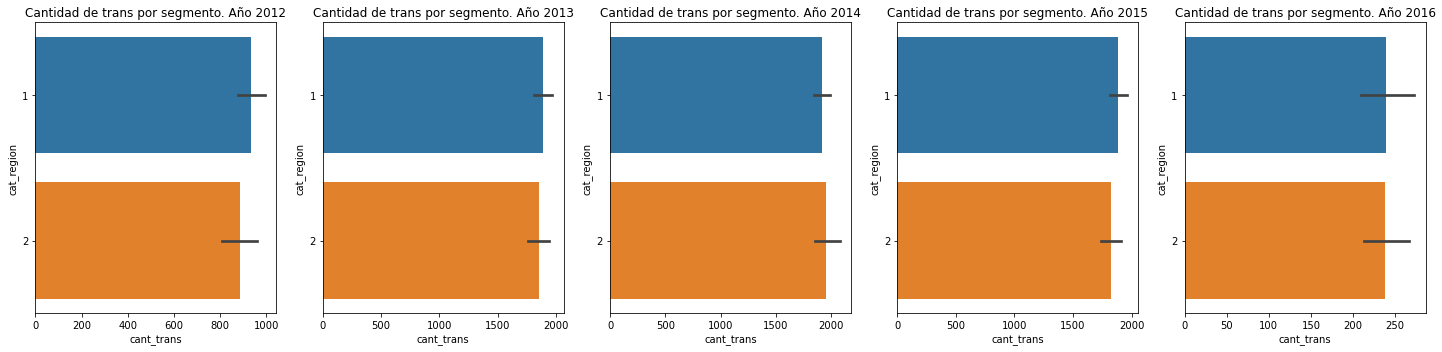

In [146]:
# Generamos una lista vacia la cual guardará los df's por año
list_gb = []

# Iteramos sobre list_gb, aplicamos groupby
for i in query_5['Year'].unique():
    tmp = query_5[query_5['Year']==i]
    tmp_gb = tmp.groupby(['CustomerId', 'Year'])['OrderId'].count().reset_index().rename(columns={'OrderId':'cant_trans'})
    list_gb.append(tmp_gb)

# Llamamos a la tabla Customer para luego extraer el CustomerId y regiones
customer_table=pd.read_sql('SELECT Id, Region FROM Customer', conn).rename(columns={'Id':'CustomerId'})

# Generamos otra lista vacia las cual guardará los merge por año 
list_gb_2 =[]

# Iteramos y aplicamos merge con los datos de CustomerId y Region
for i in list_gb:
    tmp = pd.merge(i, customer_table, on="CustomerId", how='left')
    tmp['cat_region'] = np.where((tmp['Region'] == 'Western Europe') | (tmp['Region'] =='North America') | (tmp['Region'] =='South America'), 1, 2)
    list_gb_2.append(tmp)

# Graficamos barplot por año
fig=plt.figure(figsize=(20,5))
for i, d in enumerate(list_gb_2):
    ax=fig.add_subplot(1,5,i+1)
    sns.barplot(x="cant_trans", y="cat_region", data=d, orient='h')
    plt.title('Cantidad de trans por segmento. Año {}'.format(d['Year'].unique()[0]))

fig.tight_layout()
plt.show()


#### 2.2.3 - Pregunta 7

¿Qué puede determinar de su análisis? ¿Es posible segmentar con esta data?

**Respuesta:**

Al observar el último gráfico, podemos detectar que el nivel de transacciones (por segmento) son equilibradas. Presiento que por este grafico y sobre todo por el gráfico de la pregunta 3 (*'Trans. por mes para las categorias seleccionadas'*) las tendencias son muy parecidas. Por esto la data no es la más óptima para segmentar.

#### 2.2.4 - Pregunta 8

Si tuviera que continuar este análisis para entender mejor a sus segmentos (o hacer mejores segmentos), ¿qué datos (internos y externos) agregaría solicitaría o propondría para responder a las preguntas anteriores?

**Respuesta**

Solicitaría información que me permitiera poder segmentar por más caracteristicas. Por ejemplo, datos conductuales de los customers. Algo interesante sería saber los datos sociodemográficos de quienes consumen estos productos. Al ser un empresa que distribuye alimentos de lujo, quizas seria interesante obtener datos para poder realizar una segmentación psicográfica relacionado al estilo de vida.

### 2.3 - Preguntas avanzadas

#### 2.3.1 - Pregunta 9 

Cálculo de Churn (puede utilizar SQL u otro lenguaje): Realizando estos supuestos (y otros que encuentre necesarios):
- 1. Utilice las siguientes reglas:
    - 1. Cliente "nace" en su primera transacción
    - 2. Cliente "muere" o "churnea" a los X periodos (por determinar) de su ultima transacción.
- 2. Defina una perioricidad para la tasa de churn y justifique (puede hacer esto iterativamente realizando pruebas).
- 3. Haga los siguientes calculos:
    - 1. Determine con datos la cantidad de X periodos óptima antes de declarar una muerte (fijese en la estabilidad/inestabilidad del número, y que tenga sentido con los patrones de compra visto comunmente en estos clientes).
    - 2. Tasa de churn (clientes del periodo que **entran** en estado churn sobre los clientes totales al periodo) según periodo posible del calendario: desde la primer periodo de venta venta hasta el último fecha de venta.
    - 3. Tasa de churn según segmento de cliente
- 4. Grafique ambos calculos anteriores y comente al respecto desde el punto de vista de fechas de caidas/alzas interesantes.


#### 2.3.2 - Pregunta 10 

Predicción de Tasa de Churn (puede utilizar SQL u otro lenguaje): En base a un criterio seleccionado y justificado por ud. (basado en lo que ud. prefiera: heuristicas, estadísticas, machine learning, etc), realice la predicción que responde a: ¿cuál será la tasa de churn para n-periodos en el futuro?. 

#### 2.3.3 - Pregunta 11

¿Qué iniciativas basadas en datos propondría para gestionar esta tasa?